# Netflix recommendations

<div class="alert alert-block alert-warning">
Replace <code>YOUR_GITHUB_TOKEN</code> in the install script. To get your token follow the instructions in the <a href="../README.md">README.md</a>
</div>

## Boilerplate

### Installation

In [1]:
%pip install  'https://us-central1-data-359211.cloudfunctions.net/github-proxy/superlinked-2.14.1-py3-none-any.whl?token=YOUR_GITHUB_TOKEN'

### Imports and constants

In [2]:
from datetime import timedelta, datetime

import altair as alt
import pandas as pd

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import String, Timestamp
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import InMemoryExecutor, InMemoryApp
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.query.result import Result
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.recency_space import RecencySpace

alt.renderers.enable('mimetype')

In [3]:
MODEL = "sentence-transformers/paraphrase-MiniLM-L3-v2"
YEAR_IN_DAYS = 365
TOP_N = 10
DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-netflix-shows-dataset/titles.csv"

## Prepare dataset

In [4]:
movie_df = pd.read_csv(DATASET_URL)
movie_df = movie_df[["description", "genres", "title", "release_year", "id"]].drop_duplicates(subset=["description"]).dropna(how='any')
movie_df["genres"] = movie_df["genres"].apply(lambda x: " ".join(eval(x)))
movie_df["timestamp"] = [pd.Timestamp(year=year, month=1, day=1).timestamp() for year in movie_df["release_year"].tolist()]
movie_df.head()

,description,genres,title,release_year,id,timestamp
0,This collection includes 12 World War II-era p...,documentation,Five Came Back: The Reference Films,1945,ts300399,-788918400.0
1,A mentally unstable Vietnam War veteran works ...,drama crime,Taxi Driver,1976,tm84618,189302400.0
2,Intent on seeing the Cahulawassee River before...,drama action thriller european,Deliverance,1972,tm154986,63072000.0
3,"King Arthur, accompanied by his squire, recrui...",fantasy action comedy,Monty Python and the Holy Grail,1975,tm127384,157766400.0
4,12 American military prisoners in World War II...,war action,The Dirty Dozen,1967,tm120801,-94694400.0


## Set up Superlinked

In [5]:
@schema
class MovieSchema:
    description: String
    title: String
    release_timestamp: Timestamp
    genres: String
    id: IdField

In [6]:
movie = MovieSchema()

In [7]:
description_space = TextSimilaritySpace(text=movie.description, model=MODEL)
title_space = TextSimilaritySpace(text=movie.title, model=MODEL)
genre_space = TextSimilaritySpace(text=movie.genres, model=MODEL)
recency_space = RecencySpace(timestamp=movie.release_timestamp, period_time_list=[
    PeriodTime(timedelta(days=4 * YEAR_IN_DAYS)), 
    PeriodTime(timedelta(days=10 * YEAR_IN_DAYS)), 
    PeriodTime(timedelta(days=40 * YEAR_IN_DAYS))],
    negative_filter=-0.25)

In [8]:
movie_index = Index(spaces=[description_space, title_space, genre_space, recency_space])

In [9]:
query_text_param = Param("query_text")

simple_query = (
    Query(movie_index, weights={
        description_space: Param("description_weight"),
        title_space: Param("title_weight"),
        genre_space: Param("genre_weight"),
        recency_space: Param("recency_weight")
    })
    .find(movie)
    .similar(description_space.text, query_text_param)
    .similar(title_space.text, query_text_param)
    .similar(genre_space.text, query_text_param)
    .limit(10)
)

advanced_query = (
    Query(movie_index, weights={
        description_space: Param("description_weight"),
        title_space: Param("title_weight"),
        genre_space: Param("genre_weight"),
        recency_space: Param("recency_weight")
    })
    .find(movie)
    .similar(description_space.text, Param("description_query_text"))
    .similar(title_space.text, Param("title_query_text"))
    .similar(genre_space.text, Param("genre_query_text"))
    .limit(10)
)

In [10]:
df_parser = DataFrameParser(schema=movie, mapping={movie.release_timestamp: "timestamp"})

In [11]:
source: InMemorySource = InMemorySource(movie, parser=df_parser)
executor: InMemoryExecutor = InMemoryExecutor(sources=[source], indices=[movie_index])
app: InMemoryApp = executor.run()

This next one might take several minutes to run. Getting a coffee or water, or doing a quick planking workout is advised.

In [12]:
source.put([movie_df])

## Understanding recency

Recency can seem quite complex at first, let's see how the score looks like for the relevant time periods

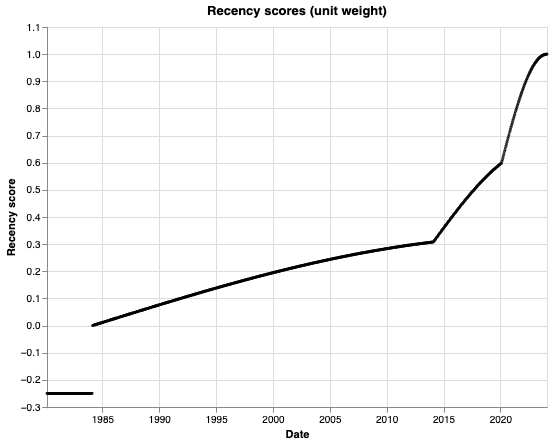

In [13]:
recency_plotter = RecencyPlotter(recency_space)
chart = recency_plotter.plot_recency_curve()
chart

notice the breaks in the score at 4, 10 and 40 years - those are our period times. Titles older than 40 years get `negative_filter` score.

## Run queries

Let's define a quick util function to present our results in the notebook

In [14]:
def present_result(result: Result, cols_to_keep: list[str] = ["description", "title", "genres", "release_year", "id"]) -> pd.DataFrame:
    # parse result to dataframe
    df: pd.DataFrame = pd.DataFrame([entry.stored_object for entry in result.entries])
    # transform timestamp back to release year
    df["release_year"] = [datetime.fromtimestamp(timestamp).year for timestamp in df["release_timestamp"]]
    return df[cols_to_keep]

### Search with user queries

With the simple query, I can search with my text in all of the fields

In [15]:
result: Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0
)

present_result(result)

,description,title,genres,release_year,id
0,When a group of people meets at the same party...,"Love, Surreal and Odd",comedy romance,2017,tm313118
1,'Love Actually' follows the lives of eight ver...,Love Actually,drama comedy romance,2003,tm133767
2,A young woman develops romantic feelings for h...,Must Be... Love,comedy romance,2013,tm188290
3,Romantic anthology web series revolving around...,Love Daily,drama romance,2018,ts90869
4,"Love You, is a 2011 Taiwanese drama starring J...",Drunken to Love You,comedy drama romance,2011,ts44064
5,Laida Magtalas is a modern-day Belle who works...,A Very Special Love,comedy drama romance,2008,tm28024
6,It tells the love story of two childhood sweet...,A Love So Beautiful,comedy romance,2017,ts77034
7,Christina's love life is stuck in neutral. Aft...,The Sweetest Thing,comedy romance,2002,tm111600
8,Mike Birbiglia shares a lifetime of romantic b...,Mike Birbiglia: My Girlfriend's Boyfriend,comedy documentation romance,2013,tm171965
9,"An LA girl, unlucky in love, falls for an East...",Love Hard,romance comedy,2021,tm1093099


After looking at the results, I see some titles I have already seen. I can bias towards recent titles by upweighting recency. Weights are normalised to have unit sum, so you don't have to worry about how you set them.

In [16]:
result: Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=3
)

present_result(result)

,description,title,genres,release_year,id
0,"In this romantic comedy, several friends, each...",F*ck Love Too,comedy romance,2022,tm1203307
1,"Fidelity tells a story of marital fidelity, in...","Devotion, a Story of Love and Desire",drama romance,2022,ts280892
2,This black humor pan-Arabic anthology series i...,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
3,A relatable romance drama about a couple in th...,Welcome to Wedding Hell,drama romance,2022,ts344043
4,An ad executive and a fashion designer-blogger...,Love Tactics,comedy romance,2022,tm1152224
5,Often (mis)guided by a cheeky imaginary wizard...,Eternally Confused and Eager for Love,comedy romance,2022,ts330012
6,Guille decides it's time to take the next step...,"Let's Tie the Knot, Honey!",comedy romance,2022,tm1204412
7,A modern love story set in the near future whe...,AI Love You,scifi comedy romance drama,2022,tm1160424
8,"After his ad agency goes bankrupt, an indebted...",Doom of Love,romance drama,2022,tm1218702
9,A wife who feels suffocated by her husband's i...,Hey! Sinamika,drama romance,2022,tm1143258


Still using the simple query, I can give more weight to spaces if I think my query is more related to that space - matches there should count more. Here I give additional weight to the genre, leave the description as is, and downweight the title as my query text is mostly a genre with some additional context. I keep recency with unit weight too, as I would like my results to be a bit biased towards recent movies.

In [17]:
result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=0.1,
    genre_weight=2,
    recency_weight=1
)

present_result(result)

,description,title,genres,release_year,id
0,"In this romantic comedy, several friends, each...",F*ck Love Too,comedy romance,2022,tm1203307
1,"An LA girl, unlucky in love, falls for an East...",Love Hard,romance comedy,2021,tm1093099
2,A relatable romance drama about a couple in th...,Welcome to Wedding Hell,drama romance,2022,ts344043
3,This black humor pan-Arabic anthology series i...,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
4,In this rom-com challenging the concept of sou...,Four to Dinner,comedy romance,2022,tm1137862
5,Short films follow young adults as they naviga...,Feels Like Ishq,drama romance comedy,2021,ts283610
6,Todd and Rory are intellectual soul mates. He ...,Straight Up,comedy romance,2019,tm494295
7,Guille decides it's time to take the next step...,"Let's Tie the Knot, Honey!",comedy romance,2022,tm1204412
8,Incurable romantic Lotte's life is upended whe...,Just Say Yes,comedy romance,2021,tm904862
9,"In pursuit of both success and validation, a g...",Slay,romance comedy,2021,tm1038025


With the advanced query, I can even supply different search terms for each attribute of the movie.

In [18]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0
)

present_result(result)

,description,title,genres,release_year,id
0,'Love Actually' follows the lives of eight ver...,Love Actually,drama comedy romance,2003,tm133767
1,Rebellious Mickey and good-natured Gus navigat...,Love,comedy drama romance,2016,ts38511
2,A rising black painter tries to break into a c...,Really Love,romance drama,2020,tm946360
3,"An LA girl, unlucky in love, falls for an East...",Love Hard,romance comedy,2021,tm1093099
4,Romantic anthology web series revolving around...,Love Daily,drama romance,2018,ts90869
5,Adam and Marklin’s 5-year relationship has gon...,Almost Love,comedy drama romance,2019,tm472195
6,Laida Magtalas is a modern-day Belle who works...,A Very Special Love,comedy drama romance,2008,tm28024
7,Two young kids fall in love with each other. B...,Endless Love,romance drama,1981,tm130586
8,Love is as tough as it is sweet for a lovestru...,A Love So Beautiful,comedy drama,2020,ts357033
9,A young woman develops romantic feelings for h...,Must Be... Love,comedy romance,2013,tm188290


And even give different weights to each subsearch if I really do care that the title is related to love but I am not really emotionally attached to my description of the movie I would want to see.

In [19]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=0
)

present_result(result)

,description,title,genres,release_year,id
0,Rebellious Mickey and good-natured Gus navigat...,Love,comedy drama romance,2016,ts38511
1,'Love Actually' follows the lives of eight ver...,Love Actually,drama comedy romance,2003,tm133767
2,The story of a family and the various situatio...,Love,thriller drama,2020,tm946277
3,A rising black painter tries to break into a c...,Really Love,romance drama,2020,tm946360
4,Adam and Marklin’s 5-year relationship has gon...,Almost Love,comedy drama romance,2019,tm472195
5,Two young kids fall in love with each other. B...,Endless Love,romance drama,1981,tm130586
6,"The story of Richard and Mildred Loving, an in...",Loving,drama romance,2016,tm219233
7,Laida Magtalas is a modern-day Belle who works...,A Very Special Love,comedy drama romance,2008,tm28024
8,"Love, Now is a 72 episode Taiwanese idol roman...","Love, Now",drama,2012,ts69208
9,Ian Montes is a picture of success. Despite be...,A Love Story,drama romance,2007,tm76399


Then I can bias again towards recent movies

In [20]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=5
)

present_result(result)

,description,title,genres,release_year,id
0,"After his ad agency goes bankrupt, an indebted...",Doom of Love,romance drama,2022,tm1218702
1,An ad executive and a fashion designer-blogger...,Love Tactics,comedy romance,2022,tm1152224
2,"Fidelity tells a story of marital fidelity, in...","Devotion, a Story of Love and Desire",drama romance,2022,ts280892
3,This black humor pan-Arabic anthology series i...,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
4,A modern love story set in the near future whe...,AI Love You,scifi comedy romance drama,2022,tm1160424
5,Often (mis)guided by a cheeky imaginary wizard...,Eternally Confused and Eager for Love,comedy romance,2022,ts330012
6,"An LA girl, unlucky in love, falls for an East...",Love Hard,romance comedy,2021,tm1093099
7,The story of a family and the various situatio...,Love,thriller drama,2020,tm946277
8,Haruto Asakura falls in love with hairdresser ...,Love Like the Falling Petals,drama romance,2022,tm1119015
9,"Inside a national weather service, love proves...",Forecasting Love and Weather,drama romance,2022,ts319412


Or maybe to older ones

In [21]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=-10
)

present_result(result)

,description,title,genres,release_year,id
0,Two young kids fall in love with each other. B...,Endless Love,romance drama,1981,tm130586
1,"Anil, a street singer, is humiliated and drive...",Disco Dancer,drama romance,1982,tm52815
2,An honest man dreams of a better life for his ...,Ujala,romance crime drama,1959,tm358653
3,Two talented song-and-dance men team up after ...,White Christmas,romance comedy,1954,tm16479
4,"Brian Cohen is an average young Jewish man, bu...",Life of Brian,comedy,1979,tm70993
5,Geeky student Arnie Cunningham falls for Chris...,Christine,horror thriller european,1983,tm54450
6,Maharaj Brajbhan lives a wealthy lifestyle in ...,Bandie,drama action romance,1978,tm16812
7,Shahjada Ijjat Beg comes to India with his car...,Sohni Mahiwal,romance drama action,1984,tm172482
8,Two small children and a ship's cook survive a...,The Blue Lagoon,romance action drama,1980,tm98978
9,"In the 1930s, bored waitress Bonnie Parker fal...",Bonnie and Clyde,crime drama action,1967,tm119281


notice that every movie before 1984 has the same recency score as our largest period time is 40 years.

### Search with a movie and queries

Now I found a movie in the last result set that I have already seen but I would love something similar. White Christmas (1954) is a story about people forming a rock-band and of course there is some love along the way. It has the id "tm16479".

I can query my dataset using this movie, too! Let's adjust the defined query first:

In [22]:
with_movie_query = advanced_query.with_vector(movie, Param("movie_id"))

with this modification, I can add a movie from the dataset to the search.

Let's first just focus on movies with similar descriptions. The first result will of course be the movie we are searching with.

In [23]:
result = app.query(
    with_movie_query,
    description_query_text="",
    title_query_text="",
    genre_query_text="",
    description_weight=1,
    title_weight=0,
    genre_weight=0,
    recency_weight=0,
    movie_id="tm16479"
)

present_result(result)

,description,title,genres,release_year,id
0,Two talented song-and-dance men team up after ...,White Christmas,romance comedy,1954,tm16479
1,"Aditya, Joe, Kedar and Rob form a rock band, b...",Rock On!!,drama music,2008,tm37945
2,Go backstage with French rap duo Bigflo & Oli ...,Bigflo & Oli: Hip Hop Frenzy,documentation music,2020,tm937044
3,A dream of the hope for intimacy and love in a...,Condom Lead,drama,2013,tm1036195
4,A duo of street performers learns how sound an...,Silent,animation family action,2014,tm137379
5,Childhood friends Suresh and Vinnie want to be...,ABCD 2,music drama,2015,tm207668
6,This documentary spotlights Debbie Allen's car...,Dance Dreams: Hot Chocolate Nutcracker,documentation family,2020,tm946927
7,Follow the lives of an elite group of young da...,The Next Step,drama family romance,2013,ts35282
8,"Sing along and dance with Bailey, Franny, Kip,...",Word Party Songs,animation family,2020,ts251607
9,Nine struggling musicians share the spotlight ...,Westside,reality,2018,ts84644


I got back movies that focus more on the rock-band aspect of the movie. With query parameters I can try to skew the results to be more related to family.

In [24]:
result = app.query(
    with_movie_query,
    description_query_text="family",
    title_query_text="",
    genre_query_text="",
    description_weight=1,
    title_weight=0,
    genre_weight=0,
    recency_weight=0,
    description_query_weight=1,
    movie_id="tm16479"
)

present_result(result)

,description,title,genres,release_year,id
0,Two talented song-and-dance men team up after ...,White Christmas,romance comedy,1954,tm16479
1,Romantic comedy following four couples who mee...,"All's Well, Ends Well",romance comedy,2012,tm37573
2,An estranged family gathers together in New Yo...,The Meyerowitz Stories (New and Selected),comedy drama,2017,tm244206
3,Years after his father disowns his adopted bro...,Kabhi Khushi Kabhie Gham,drama romance,2001,tm36475
4,Reunited in their hometown for their father's ...,The Bros,comedy fantasy,2017,tm357708
5,"A new couple, their exes and their children na...",Bonus Family,drama comedy reality family documentation musi...,2017,ts55939
6,Three prosperous women -- including a mother a...,Playing with Fire,drama,2019,ts87680
7,A young couple dream of growing old together a...,The Hows of Us,drama romance comedy,2018,tm430059
8,A dramatic story about a girl and her giving f...,Sen Benim HerŞeyimsin,comedy,2016,tm311456
9,"The loves, heartbreak, jealousy and pain of th...",The Beauty Queen of Jerusalem,drama,2021,ts252119


Taking a closer look at the description of these result movies, we can see that they share some aspect of the movie we are searching with - blended together with some notion of family:

In [25]:
res = present_result(result)
for i in res.index:
    print(i, res.loc[i].description)
    print("")

0 Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes sisters who comprise a sister act.

1 Romantic comedy following four couples who meet through a dating website. Four men go on a heroic mission to help four women and wind up experiencing a series of mishaps.

2 An estranged family gathers together in New York for an event celebrating the artistic work of their father.

3 Years after his father disowns his adopted brother for marrying a woman of lower social standing, a young man goes on a mission to reunite his family.

4 Reunited in their hometown for their father's funeral, two self-interested brothers meet a peculiar woman who shares a huge secret about their family.

5 A new couple, their exes and their children navigate the emotional challenges and tricky logistics of blended family life in this Swedish dramedy.

6 Three prosperous women -- inc

After all, this evening I am in the mood for something light - I can also skew the results towards a specific genre: comedy

In [26]:
result = app.query(
    with_movie_query,
    description_query_text="",
    title_query_text="",
    genre_query_text="comedy",
    description_weight=1,
    title_weight=0,
    genre_weight=2,
    recency_weight=0,
    description_query_weight=1,
    movie_id="tm16479"
)

present_result(result)

,description,title,genres,release_year,id
0,Two talented song-and-dance men team up after ...,White Christmas,romance comedy,1954,tm16479
1,Romantic comedy following four couples who mee...,"All's Well, Ends Well",romance comedy,2012,tm37573
2,"On a bet, a gridiron hero at John Hughes High ...",Not Another Teen Movie,comedy,2001,tm58382
3,"An original twist on an eternal triangle, wher...",Don't Go Breaking My Heart,romance comedy,2011,tm176128
4,Get ready to scream with laughter! Sam Kinison...,Sam Kinison: Family Entertainment Hour,comedy,1991,tm8687
5,The story of Nola Darling's simultaneous sexua...,She's Gotta Have It,romance comedy,1986,tm117580
6,"A vibrant, hopelessly romantic physiotherapist...",Khoobsurat,comedy romance,2014,tm158980
7,On the eve of Nikhil and Karishma’s engagement...,Hasee Toh Phasee,comedy romance,2014,tm148457
8,A young woman develops romantic feelings for h...,Must Be... Love,comedy romance,2013,tm188290
9,A sitcom about a British-Nigerian family livin...,Meet the Adebanjos,comedy,2012,ts167724
